In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## PINN: Solve 1st Order ODE

$$\frac{du}{dt} = \cos(2\pi t), \quad u(0) = 1\quad t\in [0, 2]$$

### Manual Training

In [2]:
def u_exact(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_t - torch.cos(2 * np.pi * t)
    return torch.mean(residual**2)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 2, 51)
t = torch.tensor(t_np).float().view(-1, 1).to(device)

## Initial points: initial condition loss
t0 = torch.tensor(0).float().view(-1, 1).to(device)
u0 = torch.tensor(1).float().view(-1, 1).to(device)

## Data points: data loss
n_data = 20
t_data_np = np.linspace(0.25, 1, n_data) + np.random.randn(n_data) * 0.1
u_data_np = u_exact(t_data_np) +  np.random.randn(n_data) * 0.1
t_data = torch.tensor(t_data_np).float().view(-1, 1).to(device)
u_data = torch.tensor(u_data_np).float().view(-1, 1).to(device)

In [3]:
## Model
model = nn.Sequential(
    nn.Linear(1, 20),  nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 1),
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Training
n_epochs = 10000
for epoch in range(1, n_epochs + 1):
    loss_res = residual_loss(model, t)                  ## residaul loss
    loss_ic = torch.mean((model(t0) - u0)**2)           ## initial condition loss
    loss_data = torch.mean((model(t_data) - u_data)**2) ## data loss

    total_loss = loss_res + loss_ic + loss_data

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch[{epoch}/{n_epochs}] total: {total_loss.item():.2e} "
              f"res: {loss_res.item():.2e} ic: {loss_ic.item():.2e} "
              f"data: {loss_data.item():.2e}")

/home/nam/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch[1000/10000] total: 2.80e-01 res: 2.71e-01 ic: 2.09e-04 data: 8.36e-03
Epoch[2000/10000] total: 9.66e-03 res: 9.32e-04 ic: 4.68e-05 data: 8.68e-03
Epoch[3000/10000] total: 9.39e-03 res: 6.64e-04 ic: 4.56e-05 data: 8.68e-03
Epoch[4000/10000] total: 9.23e-03 res: 5.22e-04 ic: 4.80e-05 data: 8.66e-03
Epoch[5000/10000] total: 9.15e-03 res: 4.46e-04 ic: 5.00e-05 data: 8.66e-03
Epoch[6000/10000] total: 9.09e-03 res: 3.77e-04 ic: 5.14e-05 data: 8.66e-03
Epoch[7000/10000] total: 9.13e-03 res: 3.32e-04 ic: 1.57e-04 data: 8.64e-03
Epoch[8000/10000] total: 9.02e-03 res: 2.96e-04 ic: 5.25e-05 data: 8.67e-03
Epoch[9000/10000] total: 9.00e-03 res: 2.79e-04 ic: 5.54e-05 data: 8.67e-03
Epoch[10000/10000] total: 8.99e-03 res: 2.59e-04 ic: 4.66e-05 data: 8.68e-03


### Trainer

In [4]:
from pinn import PINN, Trainer, gradient, to_tensor

def u_exact(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    residual = u_t - torch.cos(2 * np.pi * t)
    return torch.mean(residual**2)

def to_tensor(x):
    return torch.tensor(x).float().view(-1, 1).to(device)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 2, 51)
t = to_tensor(t_np)

## Initial points: initial condition loss
t0 = to_tensor(0)
u0 = to_tensor(1)

## Data points: data loss
n_data = 20
t_data_np = np.linspace(0.25, 1, n_data) + np.random.randn(n_data) * 0.1
u_data_np = u_exact(t_data_np) +  np.random.randn(n_data) * 0.1
t_data = to_tensor(t_data_np)
u_data = to_tensor(u_data_np)

Epoch[10000/10000] (lr: 6.30e-04) TOTAL: 1.16e-02, RESIDUAL: 1.40e-04, IC: 9.73e-07, DATA: 1.15e-02: 100%|#######################################################| 10000/10000 [00:45<00:00, 221.49it/s]


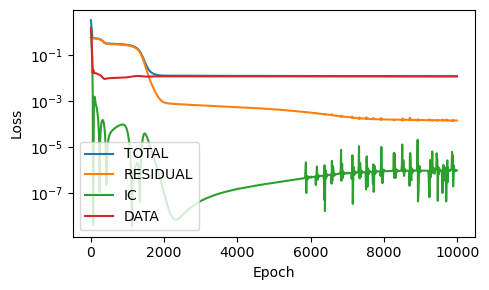

In [17]:
loss_functions = {}     # { name: loss_fn, ... }
loss_functions["residual"] = residual_loss

targets = {}            # { name: (target_inputs, target_output), ... }
targets["ic"] = to_tensor(0), to_tensor(1)
targets["data"] = t_data, u_data

model = PINN(layers_dim=[1, 20, 20, 1], activation="tanh").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

solver = Trainer(model, optimizer, loss_functions, targets)
solver.fit(t, n_epochs, scheduler=scheduler, update_step=20)
solver.show_history()

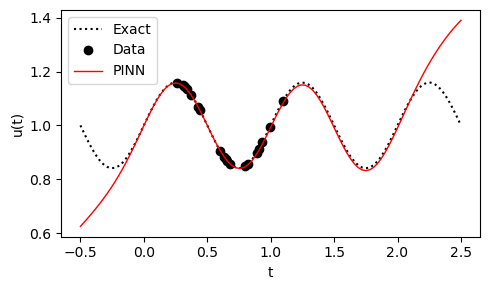

In [19]:
t_test_np = np.linspace(-0.5, 2.5, 101)
t_test = to_tensor(t_test_np)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_data_np, u_exact(t_data_np), 'ko', label="Data")
ax.plot(t_test_np, solver.predict(t_test), 'r', lw=1, label="PINN")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()